<a href="https://colab.research.google.com/github/ugnet/Faster-RCNN/blob/main/Faster_RCNN_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import numpy as np
from torchvision import transforms, datasets
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import csv
from skimage.io import imread_collection
import os
from csv import reader
import pandas as pd

NOT_FOUND = "not_found"
CLASS_BEE = "/m/01h3n"
CLASS_FRUIT = "/m/02xwb"
CLASS_SEAFOOD = "/m/06nwz"
label_types = [CLASS_BEE, CLASS_FRUIT, CLASS_SEAFOOD]

#csv file paths
test_csv_path = '/content/drive/MyDrive/GMM/OIDv4_ToolKit/OID/csv_folder/test-annotations-bbox.csv'
train_csv_path = '/content/drive/MyDrive/GMM/OIDv4_ToolKit/OID/csv_folder/train-annotations-bbox.csv'
validate_csv_path = '/content/drive/MyDrive/GMM/OIDv4_ToolKit/OID/csv_folder/validation-annotations-bbox.csv'

TEST_BEE_IMAGES = "/content/drive/MyDrive/GMM/OIDv4_ToolKit/OID/Dataset/test/Bee"
TEST_FRUIT_IMAGES = "/content/drive/MyDrive/GMM/OIDv4_ToolKit/OID/Dataset/test/Fruit"
TEST_SEAFOOD_IMAGES = "/content/drive/MyDrive/GMM/OIDv4_ToolKit/OID/Dataset/test/Seafood"

TRAIN_BEE_IMAGES = "/content/drive/MyDrive/GMM/OIDv4_ToolKit/OID/Dataset/train/Bee"
TRAIN_FRUIT_IMAGES = "/content/drive/MyDrive/GMM/OIDv4_ToolKit/OID/Dataset/train/Fruit"
TRAIN_SEAFOOD_IMAGES = "/content/drive/MyDrive/GMM/OIDv4_ToolKit/OID/Dataset/train/Seafood"

test_image_paths = [TEST_BEE_IMAGES, TEST_FRUIT_IMAGES, TEST_SEAFOOD_IMAGES]
train_image_paths = [TRAIN_BEE_IMAGES, TRAIN_FRUIT_IMAGES, TRAIN_SEAFOOD_IMAGES]

TEST_PURPOSE = "test"
TRAIN_PURPOSE = "train"

root_path = '/content/drive/MyDrive/GMM/OIDv4_ToolKit/OID/Dataset/test/Bee'

#your path 
bee_images_dir = '/content/drive/MyDrive/GMM/OIDv4_ToolKit/OID/Dataset/test/Bee/*.jpg'
bee_images = imread_collection(bee_images_dir)

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# our module
class FasterRCNN(nn.Module):
  def __init__(self):
    super.__init__()
    self.vgg = VGG16()


class TwoLayerNet(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        """
        In the constructor we instantiate two nn.Linear modules and assign them as
        member variables.
        """
        super(TwoLayerNet, self).__init__()
        self.linear1 = torch.nn.Linear(D_in, H)
        self.linear2 = torch.nn.Linear(H, D_out)

    def forward(self, x):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Tensors.
        """
        h_relu = self.linear1(x).clamp(min=0)
        y_pred = self.linear2(h_relu)
        return y_pred

class FasterRCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(1, 128, 3)
        # self.linear = nn.Linear(256, 2)
        self.linear = MyLinearLayer(256, 2)

    def forward(self, x):
        x = self. conv(x)
        x = x.view(-1, 256)
        return self.linear(x)

class RPNLayer(nn.Module): #layer
    """ Custom Linear layer but mimics a standard linear layer """
    def __init__(self, size_in, size_out):
        super().__init__()
        self.size_in, self.size_out = size_in, size_out
        weights = torch.Tensor(size_out, size_in)
        self.weights = nn.Parameter(weights)  # nn.Parameter is a Tensor that's a module parameter.
        bias = torch.Tensor(size_out)
        self.bias = nn.Parameter(bias)

        # initialize weights and biases
        nn.init.kaiming_uniform_(self.weights, a=math.sqrt(5)) # weight init
        fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weights)
        bound = 1 / math.sqrt(fan_in)
        nn.init.uniform_(self.bias, -bound, bound)  # bias init

    def forward(self, feature_map):
        feature_map = torch.mm(x, self.weights.t())
        return torch.add(w_times_x, self.bias)  # w times x + b

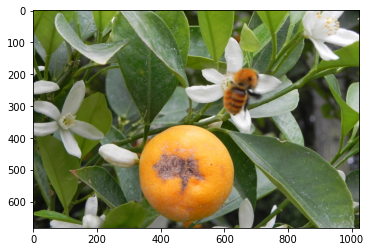

(683, 1024, 3)
the shape of loaded image transformed into numpy array: (683, 1024, 3)
transformed image: [[[ 14 134  99]
  [ 15 135 100]
  [ 15 135 100]
  ...
  [ 23  37  31]
  [ 23  37  31]
  [ 24  38  32]]

 [[ 14 134  99]
  [ 15 135 100]
  [ 15 135 100]
  ...
  [ 24  38  32]
  [ 24  38  32]
  [ 24  38  32]]

 [[ 16 133 100]
  [ 17 134 101]
  [ 15 135 101]
  ...
  [ 25  40  32]
  [ 25  40  32]
  [ 25  40  32]]

 ...

 [[ 24  26  26]
  [ 26  28  28]
  [ 30  32  32]
  ...
  [ 23  56  42]
  [ 24  56  45]
  [ 26  58  47]]

 [[ 24  26  26]
  [ 26  28  28]
  [ 29  31  31]
  ...
  [ 26  59  45]
  [ 27  59  48]
  [ 29  61  50]]

 [[ 24  26  26]
  [ 26  28  28]
  [ 28  30  30]
  ...
  [ 29  62  48]
  [ 30  62  51]
  [ 32  64  53]]]
siiize torch.Size([1, 3, 800, 800])


In [69]:
import torch

#image = cv2.imread('/content/drive/MyDrive/GMM/OIDv4_ToolKit/OID/Dataset/test/Bee/000e4e7ed48c932d.jpg')

def get_image(path):
  return cv2.imread(path)

def display_image(image):
  img_cvt=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  plt.imshow(img_cvt)
  plt.show()


image = get_image('/content/drive/MyDrive/GMM/OIDv4_ToolKit/OID/Dataset/test/Bee/000e4e7ed48c932d.jpg')
display_image(image)
# image = torch.zeros((1, 3, 800, 800)).float()
# print(image)

# transform Image into the numpy array
image_2_npArray = np.asarray(image)
print(np.shape(image_2_npArray))
print('the shape of loaded image transformed into numpy array: {}'.format(np.shape(image_2_npArray)))
print('transformed image: {}'.format(image_2_npArray))

# transform the numpy array into the tensor
image = torchvision.transforms.ToTensor()(image_2_npArray)
# add one more dimension
image = image.unsqueeze(0)


#resize
image = F.interpolate(image, 800)
print('siiize', image.shape)
#print('transformed numpy array: {}'.format(tensor))
# tensor = torch.reshape(tensor, (1, 3, 800, 800))
# print(tensor.shape())

In [19]:
  img = cv2.imread('/content/drive/MyDrive/GMM/OIDv4_ToolKit/OID/Dataset/test/Bee/000e4e7ed48c932d.jpg')
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#[595.508224, 181.938906, 719.030272, 345.572046]
  show_img = img
show_image_boxes(torch.from_numpy(show_img), [{'boxes': [[ 26.5775,   0.8509, 320.0000, 167.2844], [ 40.3254,  23.8104, 210.3828, 160.8308]]}])

NameError: ignored

30
512


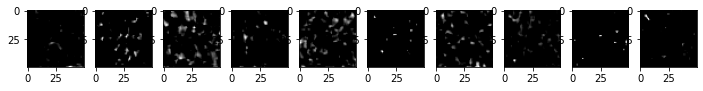

torch.Size([1, 512, 50, 50])


In [41]:
model = torchvision.models.vgg16(pretrained=True)
fe = list(model.features)

req_features = []
k = image.clone()
for i in fe:
    k = i(k)
    if k.size()[2] < 800//16:
        break
    req_features.append(i)
    out_channels = k.size()[1]

print(len(req_features)) #30
print(out_channels) # 512

faster_rcnn_fe_extractor = nn.Sequential(*req_features)

feature_map = faster_rcnn_fe_extractor(image)
vizualize_feature_maps(feature_map, 10)
print(feature_map.size())



# **Load datasets**

In [101]:
#function for vizualizing feature maps
def vizualize_feature_maps(feature_map, r):
  imgArray = feature_map.data.cpu().numpy().squeeze(0)
  fig=plt.figure(figsize=(12, 4))
  figNo=1
  for i in range(r):
    fig.add_subplot(1, r, figNo)
    plt.imshow(imgArray[i],  cmap='gray')
    figNo+=1
  plt.show()

#how to update boxes?
class MyDataset(object):
  def __init__(self):
    self.list_of_items = []
    #cia sitam metode turetu buti uzloadinami duomenys

  def __getitem__(self, index):
    return self.list_of_items[index]

  def getItemById(self, image_name):
    if ( len(self.list_of_items) == 0):
      return NOT_FOUND
    for item in self.list_of_items:
      if (item.id == image_name):
        return item
    return NOT_FOUND

  def __len__(self):
    return len(self.list_of_items)

  def addItem(self, item):
    self.list_of_items = np.append(self.list_of_items, item)

  def addBoxToItem(self, id, coordinate):
    item = self.getItemById(id)
    item.addBox(coordinate)

class Item(object):
  def __init__(self, id, name, path, item_class):
    super(Item).__init__()
    self.id = id
    self.name = name
    self.path = path
    self.item_class = item_class
    self.box_coordinates = []

  def getBoxes(self):
    return self.box_coordinates

  def addBox(self, coordonates):
    self.box_coordinates.append(coordonates)

def getImageFileNamesFromPath(directory):
  image_full_file_paths = []
  image_file_names = []

#problema cia su path
#NEGRAZINA image_full_file_paths!! BET IR NENAUDOJAM
  for path in os.listdir(directory):
      full_path = os.path.join(directory, path)
      file_name = os.path.splitext(path)[0]
      image_file_names = np.append(image_file_names, file_name)
      if os.path.isfile(path):
        image_full_file_paths = np.append(image_full_file_paths, full_path)

  return [image_full_file_paths, image_file_names]

#paduodame atrinktas csv failo eilutes turincias tik bbox'us mus dominancioms klasems
def createDataset(purpose, csv_rows):
  dataset = MyDataset()
  for row in csv_rows:
    id = row[0] #also id
    img_name = id + ".jpg"
    item_class = row[2]
    image_path = getRootPath(item_class, purpose) + '/' + img_name
    # if (item_class == CLASS_BEE):
    #   image_path = root_path + img_name
    coordinate = [row[4], row[5], row[6], row[7]]
    box_coordinates = []
    box_coordinates.append(coordinate)

    if (dataset.getItemById(id) == NOT_FOUND):
      #print("PRIDEJOOM")
      dataset.addItem(Item(id, img_name, image_path, item_class))
      continue
    else:
      #print("JAU TUREJO")
      dataset.addBoxToItem(id, coordinate)

  return dataset

#is sio metodo gaunamas rows paduadame kurdami dataseta
def filterCsvRows(imageDirPaths, csv_file):
  imageFileNames = []
  for path in imageDirPaths:
    full, notfull = getImageFileNamesFromPath(path)
    imageFileNames = np.concatenate((imageFileNames, notfull))
  filteredRows = csv_file[(csv_file.LabelName.isin(label_types)) & (csv_file.ImageID.isin(imageFileNames))]
  filteredRows = filteredRows.values
  return filteredRows;

def getRootPath(class_name, purpose):
  if (class_name == CLASS_BEE and purpose == TEST_PURPOSE):
    return TEST_BEE_IMAGES
  elif (class_name == CLASS_BEE and purpose == TRAIN_PURPOSE):
    return TRAIN_BEE_IMAGES
  elif (class_name == CLASS_FRUIT and purpose == TEST_PURPOSE):
    return TEST_FRUIT_IMAGES
  elif (class_name == CLASS_FRUIT and purpose == TRAIN_PURPOSE):
    return TRAIN_FRUIT_IMAGES
  elif (class_name == CLASS_SEAFOOD and purpose == TEST_PURPOSE):
    return TEST_SEAFOOD_IMAGES
  elif (class_name == CLASS_SEAFOOD and purpose == TRAIN_PURPOSE):
    return TRAIN_SEAFOOD_IMAGES
  else:
    return NOT_FOUND



In [ ]:
dir = "/content/drive/MyDrive/GMM/OIDv4_ToolKit/OID/Dataset/test/Bee"
full, notfull = getImageFileNamesFromPath([dir, dir])
label_types = [CLASS_BEE, CLASS_FRUIT, CLASS_SEAFOOD]

rows = filterCsvRows(dir, csv_file)
createDataset("train", rows)
print(rows)

#rows = [row for row in csv_file if row['ImageID'] == id]



PRIDEJOOM
PRIDEJOOM
JAU TUREJO
PRIDEJOOM
PRIDEJOOM
JAU TUREJO
PRIDEJOOM
PRIDEJOOM
PRIDEJOOM
PRIDEJOOM
PRIDEJOOM
PRIDEJOOM
PRIDEJOOM
PRIDEJOOM
PRIDEJOOM
JAU TUREJO
JAU TUREJO
JAU TUREJO
JAU TUREJO
JAU TUREJO
JAU TUREJO
JAU TUREJO
JAU TUREJO
JAU TUREJO
PRIDEJOOM
PRIDEJOOM
PRIDEJOOM
JAU TUREJO
PRIDEJOOM
JAU TUREJO
JAU TUREJO
PRIDEJOOM
PRIDEJOOM
PRIDEJOOM
PRIDEJOOM
PRIDEJOOM
JAU TUREJO
JAU TUREJO
PRIDEJOOM
PRIDEJOOM
PRIDEJOOM
PRIDEJOOM
PRIDEJOOM
PRIDEJOOM
PRIDEJOOM
PRIDEJOOM
JAU TUREJO
PRIDEJOOM
PRIDEJOOM
JAU TUREJO
PRIDEJOOM
PRIDEJOOM
PRIDEJOOM
PRIDEJOOM
PRIDEJOOM
PRIDEJOOM
PRIDEJOOM
PRIDEJOOM
PRIDEJOOM
PRIDEJOOM
JAU TUREJO
PRIDEJOOM
PRIDEJOOM
PRIDEJOOM
JAU TUREJO
PRIDEJOOM
PRIDEJOOM
PRIDEJOOM
PRIDEJOOM
JAU TUREJO
JAU TUREJO
JAU TUREJO
PRIDEJOOM
PRIDEJOOM
PRIDEJOOM
PRIDEJOOM
JAU TUREJO
JAU TUREJO
JAU TUREJO
JAU TUREJO
PRIDEJOOM
PRIDEJOOM
PRIDEJOOM
PRIDEJOOM
PRIDEJOOM
PRIDEJOOM
PRIDEJOOM
JAU TUREJO
PRIDEJOOM
PRIDEJOOM
PRIDEJOOM
JAU TUREJO
PRIDEJOOM
PRIDEJOOM
PRIDEJOOM
PRIDEJOOM
PRIDEJOOM
P

In [ ]:
def draw_bounding_box(tensor, bbox, **kwargs):  # TODO: don't use a kwargs dict
    # adapted from https://pytorch.org/docs/stable/_modules/torchvision/utils.html#save_image
    from PIL import Image
    # TODO: none of the kwargs to make_grid are in this scope
    grid = make_grid(tensor, nrow=nrow, padding=padding, pad_value=pad_value,
                     normalize=normalize, range=range, scale_each=scale_each)
    # Add 0.5 after unnormalizing to [0, 255] to round to nearest integer
    ndarr = grid.mul(255).add_(0.5).clamp_(0, 255).permute(1, 2, 0).to('cpu', torch.uint8).numpy()

    # TODO: convert bbox to the appropriate type
    return cv2.rectangle(ndarr, bbox)  # use PIL if opencv-python isn't a dependency

In [43]:
# 
class RPN(nn.Module):
    
    def __init__(self, in_channels=512, mid_channels=512, n_anchor=9):
        super(RPN, self).__init__()   
        self.mid_channels = mid_channels
        self.in_channels = in_channels # depends on the output feature map. in vgg 16 it is equal to 512
        self.n_anchor = n_anchor # Number of anchors at each location
        self.conv1 = nn.Conv2d(self.in_channels, self.mid_channels, 3, 1, 1)
        self.reg_layer = nn.Conv2d(mid_channels, n_anchor *4, 1, 1, 0)
        self.cls_layer = nn.Conv2d(mid_channels, n_anchor *2, 1, 1, 0) 
        
        # conv sliding layer
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv1.bias.data.zero_()
        # Regression layer
        self.reg_layer.weight.data.normal_(0, 0.01)
        self.reg_layer.bias.data.zero_()
        # classification layer
        self.cls_layer.weight.data.normal_(0, 0.01)
        self.cls_layer.bias.data.zero_()
        
    def forward(self, k):
        bat_num = k.shape[0]
        x = self.conv1(k)
        pred_anchor_locs = self.reg_layer(x)
        pred_cls_scores = self.cls_layer(x)
        
        pred_anchor_locs = pred_anchor_locs.permute(0, 2, 3, 1).contiguous().view(bat_num, -1, 4)
        pred_cls_scores = pred_cls_scores.permute(0, 2, 3, 1).contiguous()
        objectness_score = pred_cls_scores#.view(bat_num, 50, 50, 9, 2)[:, :, :, :, 1].contiguous().view(bat_num, -1)
        pred_cls_scores  = pred_cls_scores.view(bat_num, -1, 2)
        
        return pred_anchor_locs, pred_cls_scores, objectness_score

model = RPN()
print(feature_map.shape)
result = model.forward(feature_map)
print(result)

torch.Size([1, 512, 50, 50])
(tensor([[[ 0.0085, -0.0716,  0.0470, -0.0215],
         [-0.0115,  0.0130,  0.0435,  0.0102],
         [-0.0013, -0.0381, -0.0465, -0.0132],
         ...,
         [-0.0091, -0.0083,  0.0084,  0.0041],
         [-0.0109,  0.0161,  0.0785, -0.0152],
         [-0.0023, -0.0073, -0.0385, -0.0111]]], grad_fn=<ViewBackward>), tensor([[[ 4.9557e-02,  1.5465e-02],
         [-6.4832e-03,  6.6459e-02],
         [-2.6415e-02,  9.5330e-03],
         ...,
         [ 4.4687e-02,  9.0505e-03],
         [-2.1801e-02,  1.5553e-02],
         [-1.5949e-02,  1.5669e-05]]], grad_fn=<ViewBackward>), tensor([[[[ 4.9557e-02,  1.5465e-02, -6.4832e-03,  ...,  2.9194e-02,
            7.6169e-04,  6.9974e-03],
          [ 3.2989e-03,  1.4539e-02,  1.7987e-02,  ...,  6.6609e-02,
           -2.4439e-03, -5.3134e-02],
          [-1.3502e-02,  3.4271e-02,  1.3039e-03,  ...,  6.6498e-02,
            5.8897e-03, -5.1716e-02],
          ...,
          [ 1.9985e-02, -2.5090e-02, -2.7253e-03

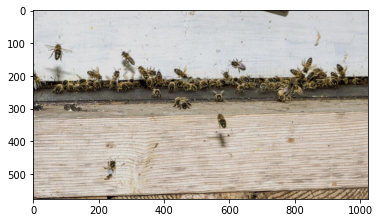

[[0.0, 1.0, 0.30954699999999996, 0.48782200000000003], [0.037938, 0.116094, 0.15567899999999998, 0.26710100000000003], [0.20498899999999998, 0.260474, 0.777519, 0.888941], [0.262861, 0.301641, 0.205553, 0.302119], [0.42156000000000005, 0.45138999999999996, 0.460232, 0.5196569999999999], [0.44005500000000003, 0.474062, 0.45068199999999997, 0.520718], [0.537899, 0.578469, 0.521779, 0.634263], [0.5814520000000001, 0.631568, 0.263917, 0.333954], [0.799216, 0.8469450000000001, 0.24375500000000003, 0.331831]]


TypeError: ignored

In [103]:
#Main

def prepareData(purpose):
  if (purpose == TEST_PURPOSE):
    #csffile that we will read
    csv_file = pd.read_csv(test_csv_path)
    rows = filterCsvRows(test_image_paths, csv_file)
    dataset = createDataset(TEST_PURPOSE, rows)
    return dataset
  elif (purpose == TRAIN_PURPOSE):
    #csffile that we will read
    csv_file = pd.read_csv(train_csv_path)
    rows = filterCsvRows(train_image_paths, csv_file)
    dataset = createDataset(TRAIN_PURPOSE, rows)
    return dataset
  else:
    return NOT_FOUND

dataset = prepareData(TEST_PURPOSE)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=3, shuffle=True, num_workers=2, collate_fn=None)
model = RPN()


path = dataset.getItemById("0f8a109dbd1784be").path
image = get_image(path)
display_image(image)
print(dataset.getItemById("0f8a109dbd1784be").box_coordinates)


dataiter =iter(data_loader)
data = dataiter.next()
items = data


#resize images
#display image with its boxes
def train_model(vgg_req_features, epochs, model, train_data_loader):
  for epoch in range(epochs):
    model.train()
    print("Epoch ", epoch)
    for image in train_data_loader:
      print("Image")
      print(image)
      break


train_model(faster_rcnn_fe_extractor, 2, model, data_loader)

